In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import label
import json
from tqdm import tqdm
import os
from scipy.interpolate import griddata
import pandas as pd

In [2]:
df = pd.read_csv("/home/ScoutJarman/Code/ILWA/data/other/usgs_data.csv", parse_dates=['datetime'])

In [3]:
df.columns

Index(['agency_cd', 'site_no', 'datetime', '255781_62615_00003',
       '255781_62615_00003_cd', '309486_00062_00003', '309486_00062_00003_cd'],
      dtype='object')

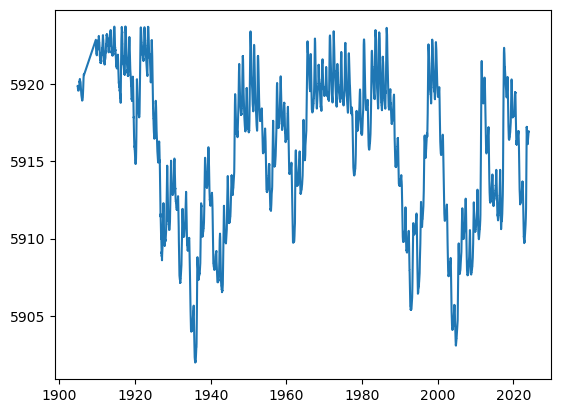

In [4]:
tmp = df[['datetime', '309486_00062_00003']].dropna()
plt.plot(tmp['datetime'], tmp['309486_00062_00003'])

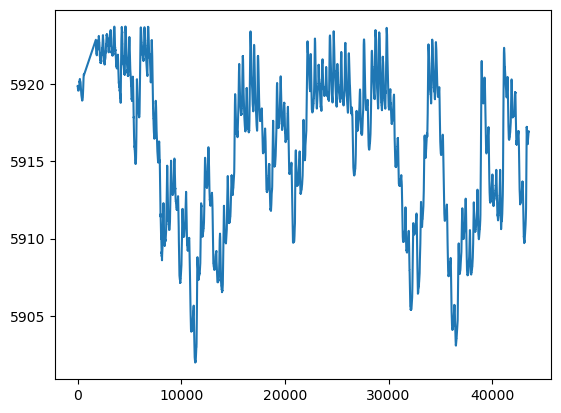

In [7]:
plt.plot(df['309486_00062_00003'].dropna())

In [2]:
shapefile_path = "/home/ScoutJarman/Code/ILWA/data/shapefiles/id_ut8_1601.shp"

watersheds = gpd.read_file(shapefile_path)
watersheds

,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,referenceg,areaacres,areasqkm,states,huc8,name,geometry
0,{E909EC67-8CE3-4B76-9837-37A1213809E2},None,None,None,None,2020-11-30,None,1285620.74,5202.73,"UT,WY",16010101,Upper Bear,"POLYGON ((-110.79684 42.05824, -110.79681 42.0..."
1,{05F97963-7BF4-40BB-9668-F40029C826E5},None,None,None,None,2020-06-04,None,524613.55,2123.04,"ID,UT,WY",16010102,Central Bear,"POLYGON ((-110.74992 42.60416, -110.74896 42.6..."
2,{08DCF3AF-261F-46A9-9628-0F17C5823D2A},None,None,None,None,2020-06-04,None,810819.31,3281.27,"ID,UT",16010201,Bear Lake,"POLYGON ((-111.64622 42.85186, -111.64584 42.8..."
3,{505FFE08-4104-4140-AC9C-D1CDF623BE15},None,None,None,None,2019-11-15,None,821269.05,3323.56,"ID,UT",16010202,Middle Bear,"POLYGON ((-111.70071 42.65360, -111.70033 42.6..."
4,{D856EF1B-AED2-49EC-94B5-1D81CA0FBDFB},None,None,None,None,2019-11-15,None,565815.71,2289.78,"ID,UT",16010203,Little Bear-Logan,"POLYGON ((-111.57944 42.09256, -111.57893 42.0..."
5,{01C57E81-D098-4902-A2FE-5C1288E42BC8},None,None,None,None,2020-11-30,None,801195.88,3242.33,"ID,UT",16010204,Lower Bear-Malad,"POLYGON ((-112.44530 42.54988, -112.44520 42.5..."


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 47,
 'height': 51,
 'count': 14610,
 'crs': CRS.from_epsg(4269),
 'transform': Affine(0.04166666666666657, 0.0, -112.5625,
        0.0, -0.04166666769212292, 42.85416776441759)}

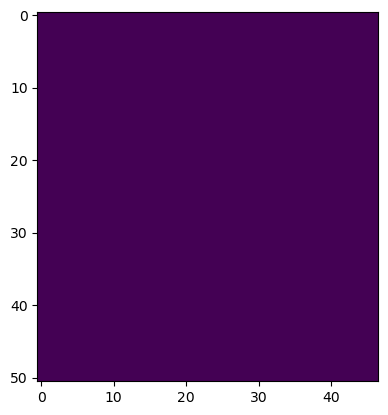

In [3]:
raster_path = "/home/ScoutJarman/Code/ILWA/data/rasters/UA/swe_81-23/swe19811001.tif"

with rasterio.open(raster_path) as handle:
    raster_arr = handle.read(1)
    meta = handle.meta

plt.imshow(raster_arr)
meta


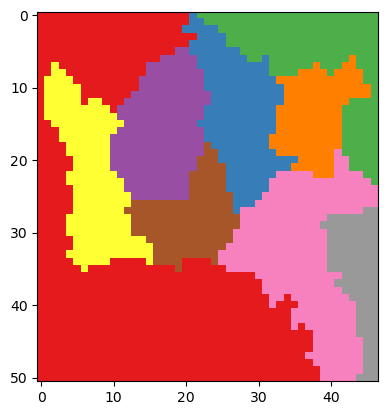

In [4]:
seg = np.zeros_like(raster_arr)
for idx, geometry in enumerate(watersheds['geometry']):
    mask = geometry_mask([geometry], out_shape=raster_arr.shape, transform=meta['transform'], invert=True)
    seg[mask] = idx + 1

seg = label(seg, background=-1) - 1
plt.imshow(seg, cmap='Set1')

Text(0, 0.5, 'Average Precip')

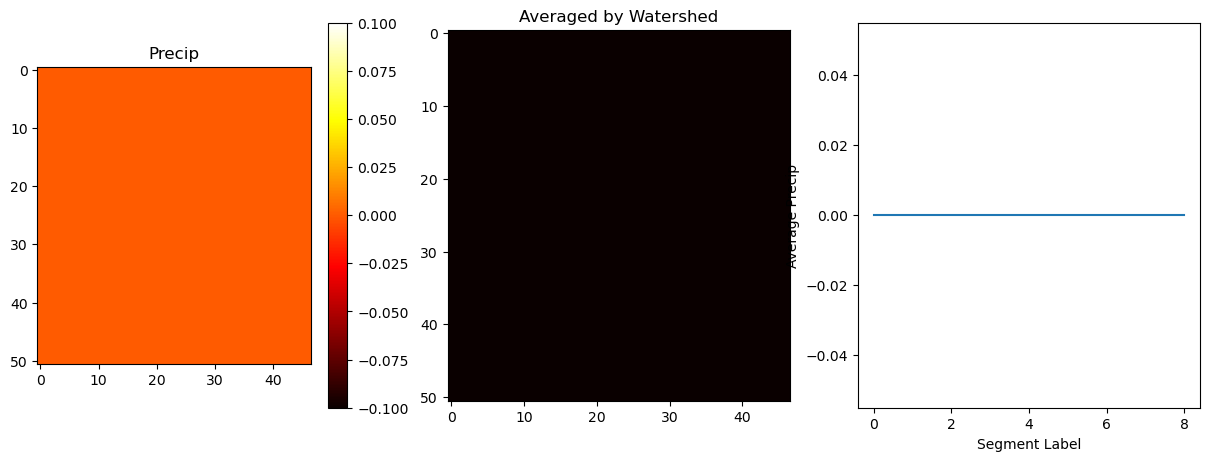

In [5]:
agg_img = np.zeros_like(raster_arr)
means = []
for l in np.unique(seg):
    m = raster_arr[seg == l].mean()
    means.append(m)
    agg_img[seg == l] = m


fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

axs[1].imshow(agg_img, cmap='hot', vmin=raster_arr.min(), vmax=raster_arr.max())
axs[1].set_title("Averaged by Watershed")
img = axs[0].imshow(raster_arr, cmap='hot')
axs[0].set_title("Precip")
plt.colorbar(img, ax=axs[0])
axs[2].plot(means)
axs[2].set_xlabel("Segment Label")
axs[2].set_ylabel("Average Precip")

# Read in SWE

In [2]:
# Read layer names from the JSON file
with open("/home/ScoutJarman/Code/ILWA/data/rasters/UA/ua_swe_daily_bearlake.tif.aux.json", 'r') as json_file:
    layer_names = json.load(json_file)['time']

input_path = "/home/ScoutJarman/Code/ILWA/data/rasters/UA/ua_swe_daily_bearlake.tif"
output_directory = "/home/ScoutJarman/Code/ILWA/data/rasters/UA/swe_81-23/"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [3]:
# Open the original raster file
with rasterio.open(input_path) as src:
    # Loop through bands and layer names
    for band_idx, layer_name in tqdm(zip(range(1, src.count + 1), layer_names), total=src.count):
        # Read the band data
        band_data = src.read(band_idx)

        # Do nearest neighbor interpolation for lake values
        non_nan_indices = np.where(~np.isnan(band_data))
        points = np.column_stack((non_nan_indices[1], non_nan_indices[0]))
        values = band_data[non_nan_indices]
        rows, cols = band_data.shape
        grid_x, grid_y = np.meshgrid(np.arange(cols), np.arange(rows))
        interpolated_values = griddata(points, values, (grid_x, grid_y), method='nearest')
        band_data[np.isnan(band_data)] = interpolated_values[np.isnan(band_data)]

        year, month, day = layer_name.split("-")
        # Create a new raster file for each band with the corresponding layer name
        output_raster_path = f"{output_directory}/swe{int(year)}{int(month):02d}{int(day):02d}.tif"

        # Write the band data to the new raster file with the same metadata
        with rasterio.open(output_raster_path, 'w', **src.profile) as dst:
            dst.write(band_data, 1)

100%|██████████| 14610/14610 [2:16:59<00:00,  1.78it/s] 


In [4]:
import os
import json
import threading
import rasterio
from joblib import Parallel, delayed
from tqdm import tqdm

def process_bands(start_band, end_band, src, output_directory):
    for band_idx in range(start_band, end_band + 1):
        layer_name = layer_names[band_idx - 1]  # Adjust index since bands are 1-indexed in rasterio
        band_data = src.read(band_idx)

        # Do nearest neighbor interpolation for NaN values
        non_nan_indices = np.where(~np.isnan(band_data))
        points = np.column_stack((non_nan_indices[1], non_nan_indices[0]))
        values = band_data[non_nan_indices]
        rows, cols = band_data.shape
        grid_x, grid_y = np.meshgrid(np.arange(cols), np.arange(rows))
        interpolated_values = griddata(points, values, (grid_x, grid_y), method='nearest')
        band_data[np.isnan(band_data)] = interpolated_values[np.isnan(band_data)]

        # Create a new raster file for each band with the corresponding layer name
        year, month, day = layer_name.split("-")
        output_raster_path = f"{output_directory}/swe{int(year)}{int(month):02d}{int(day):02d}.tif"

        # Write the band data to the new raster file with the same metadata
        with rasterio.open(output_raster_path, 'w', **src.profile) as dst:
            dst.write(band_data, 1)

# Open the original raster file
input_path = "/home/ScoutJarman/Code/ILWA/data/rasters/UA/ua_swe_daily_bearlake.tif"
with rasterio.open(input_path) as src:
    # Read layer names from the JSON file
    with open("/home/ScoutJarman/Code/ILWA/data/rasters/UA/ua_swe_daily_bearlake.tif.aux.json", 'r') as json_file:
        layer_names = json.load(json_file)['time']

    # Create output directory if it doesn't exist
    output_directory = "/home/ScoutJarman/Code/ILWA/data/rasters/UA/swe_81-23/"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Set up parallel processing using joblib
    num_bands = src.count
    bands_per_thread = 5  # Adjust as needed
    num_threads = (num_bands + bands_per_thread - 1) // bands_per_thread

    def thread_worker(start_band, end_band):
        with rasterio.open(input_path) as local_src:
            process_bands(start_band, end_band, local_src, output_directory)

    # Create threads
    threads = []
    for thread_idx in range(num_threads):
        start_band = thread_idx * bands_per_thread + 1
        end_band = min((thread_idx + 1) * bands_per_thread, num_bands)
        thread = threading.Thread(target=thread_worker, args=(start_band, end_band))
        threads.append(thread)

    # Start and wait for all threads to finish
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
